In [129]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)


In [130]:
TRAIN_PATH = "data/train.xlsx"
TEST_PATH  = "data/test.xlsx"

train_df = pd.read_excel(TRAIN_PATH)
test_df  = pd.read_excel(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()


Train shape: (4548, 28)
Test shape: (1516, 27)


,Unnamed: 0,предмет,ФИО,tutor_head_tags,tutor_rating,tutor_reviews,description,experience_desc,Education_1,Desc_Education_1,Education_2,Desc_Education_2,Education_3,Desc_Education_3,Education_4,Desc_Education_4,Ученая степень 1,Ученое звание 1,status,experience,Desc_Education_5,Desc_Education_6,Education_5,Education_6,Ученая степень 2,Ученое звание 2,categories,mean_price
0,0,matematika,Репетитор по математике Емельянова Марина Вла...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",5.0,2,Репетитор не предоставил о себе дополн...,NaN,Томский государственный университет им. В.В. ...,"Год окончания: 1990, Факультет: механико-мате...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Университетский преподаватель,31 год,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",16.666667
1,1,matematika,Репетитор по математике Назарова Анастасия Ан...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",4.0,7,Репетитор не предоставил о себе дополн...,NaN,Вологодский государственный педагогический ун...,"Год окончания: 2017, Факультет: факультет при...",Череповецкий государственный университет,"Год окончания: 2023, Факультет: институт инфо...",NaN,NaN,NaN,NaN,NaN,NaN,Школьный преподаватель,8 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",11.666667
2,2,informatika,Репетитор по информатике Мотроненко Инна Конст...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Выезд за город: Балашиха-1, Балашиха-2...",Московская Школа (учитель ...,Московский городской педагогический университет,"Год окончания: 2008, Факультет: Математически...",Московский городской педагогический университ...,"Год окончания: 2014, Факультет: Безопасность ...",Российская таможенная академия,"Год окончания: 2011, Факультет: Экономический...",NaN,NaN,NaN,NaN,Школьный преподаватель,11 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",23.333333
3,3,matematika,Репетитор по математике Логинова Елизавета Ал...,"['Школьная программа', 'Математический анализ'...",4.0,19,"Здравствуйте! Меня зовут Елизавета, о...",NaN,Санкт-Петербургский государственный университет,"Год окончания: 2021, Факультет: физический фа...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Частный преподаватель,5 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 1 по 4 класс', 'Школьники с 5 по...",0.116667
4,4,matematika,Репетитор по математике Харланов Олег Викторо...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Целеустремленный, ориентирован на резу...",преподавателем ...,Приазовский государственный технический униве...,"Год окончания: 2005, Факультет: Энергетически...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Частный преподаватель,19 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п...",16.666667


In [131]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        4548 non-null   int64  
 1   предмет           4548 non-null   object 
 2   ФИО               4548 non-null   object 
 3   tutor_head_tags   4548 non-null   object 
 4   tutor_rating      3959 non-null   float64
 5   tutor_reviews     4548 non-null   int64  
 6   description       4547 non-null   object 
 7   experience_desc   2171 non-null   object 
 8   Education_1       4548 non-null   object 
 9   Desc_Education_1  4472 non-null   object 
 10  Education_2       781 non-null    object 
 11  Desc_Education_2  777 non-null    object 
 12  Education_3       106 non-null    object 
 13  Desc_Education_3  105 non-null    object 
 14  Education_4       16 non-null     object 
 15  Desc_Education_4  16 non-null     object 
 16  Ученая степень 1  76 non-null     object 


Определены типы данных столбцов и количество пропусков.
Большинство признаков — категориальные/текстовые (object), присутствуют числовые (tutor_rating, tutor_reviews).
Также видно, что часть образовательных полей имеет большое количество пропусков, что потребует корректной обработки.

In [132]:
train_df.describe(include="all").T.head(30)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,4548.0,NaN,NaN,NaN,2273.5,1313.038842,0.0,1136.75,2273.5,3410.25,4547.0
предмет,4548,2,matematika,3685,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ФИО,4548,3817,Репетитор по информатике Минак Андрей Геннадье...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tutor_head_tags,4548,353,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",1654,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tutor_rating,3959.0,NaN,NaN,NaN,1.895933,2.280103,0.0,0.0,0.0,4.0,5.0
tutor_reviews,4548.0,NaN,NaN,NaN,2.989006,8.516939,0.0,0.0,0.0,2.0,152.0
description,4547,2765,Репетитор не предоставил о себе дополн...,1123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
experience_desc,2171,839,Репетитор не предоставил информаци...,832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_1,4548,1312,Санкт-Петербургский государственный университет,176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Desc_Education_1,4472,3640,"Год окончания: 2026, Факультет: Институт инфо...",12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получена базовая статистика по данным: распределения числовых полей, количество уникальных значений для категорий, частотность и наиболее встречаемые значения.
Это позволяет оценить масштаб категориальных признаков и потенциальную необходимость ограничения/регуляризации при OHE/TF-IDF.

In [133]:
missing = train_df.isna().mean().sort_values(ascending=False)
missing[missing > 0].head(50)

Desc_Education_6    0.999780
Education_6         0.999780
Ученое звание 2     0.999780
Ученая степень 2    0.999780
Education_5         0.999340
Desc_Education_5    0.999340
Education_4         0.996482
Desc_Education_4    0.996482
Ученое звание 1     0.992304
Ученая степень 1    0.983289
Desc_Education_3    0.976913
Education_3         0.976693
Desc_Education_2    0.829156
Education_2         0.828276
experience_desc     0.522647
tutor_rating        0.129507
Desc_Education_1    0.016711
experience          0.005497
status              0.002858
description         0.000220
dtype: float64

Выявлены признаки с критически высокой долей пропусков (например, Education_4+, Desc_Education_4+, ученые степени/звания 2).
Такие признаки потенциально могут быть либо исключены, либо обработаны стратегиями заполнения, чтобы избежать потерь данных и ошибок при обучении.

In [134]:
TARGET = "mean_price"

X = train_df.drop(columns=[TARGET]).copy()
y = train_df[TARGET].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)

X.head()

X shape: (4548, 27)
y shape: (4548,)


,Unnamed: 0,предмет,ФИО,tutor_head_tags,tutor_rating,tutor_reviews,description,experience_desc,Education_1,Desc_Education_1,Education_2,Desc_Education_2,Education_3,Desc_Education_3,Education_4,Desc_Education_4,Ученая степень 1,Ученое звание 1,status,experience,Desc_Education_5,Desc_Education_6,Education_5,Education_6,Ученая степень 2,Ученое звание 2,categories
0,0,matematika,Репетитор по математике Емельянова Марина Вла...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",5.0,2,Репетитор не предоставил о себе дополн...,NaN,Томский государственный университет им. В.В. ...,"Год окончания: 1990, Факультет: механико-мате...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Университетский преподаватель,31 год,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п..."
1,1,matematika,Репетитор по математике Назарова Анастасия Ан...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",4.0,7,Репетитор не предоставил о себе дополн...,NaN,Вологодский государственный педагогический ун...,"Год окончания: 2017, Факультет: факультет при...",Череповецкий государственный университет,"Год окончания: 2023, Факультет: институт инфо...",NaN,NaN,NaN,NaN,NaN,NaN,Школьный преподаватель,8 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п..."
2,2,informatika,Репетитор по информатике Мотроненко Инна Конст...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Выезд за город: Балашиха-1, Балашиха-2...",Московская Школа (учитель ...,Московский городской педагогический университет,"Год окончания: 2008, Факультет: Математически...",Московский городской педагогический университ...,"Год окончания: 2014, Факультет: Безопасность ...",Российская таможенная академия,"Год окончания: 2011, Факультет: Экономический...",NaN,NaN,NaN,NaN,Школьный преподаватель,11 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п..."
3,3,matematika,Репетитор по математике Логинова Елизавета Ал...,"['Школьная программа', 'Математический анализ'...",4.0,19,"Здравствуйте! Меня зовут Елизавета, о...",NaN,Санкт-Петербургский государственный университет,"Год окончания: 2021, Факультет: физический фа...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Частный преподаватель,5 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 1 по 4 класс', 'Школьники с 5 по..."
4,4,matematika,Репетитор по математике Харланов Олег Викторо...,"['Школьная программа', 'Подготовка к ЕГЭ', 'По...",0.0,0,"Целеустремленный, ориентирован на резу...",преподавателем ...,Приазовский государственный технический униве...,"Год окончания: 2005, Факультет: Энергетически...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Частный преподаватель,19 лет,NaN,NaN,NaN,NaN,NaN,NaN,"['Школьники с 5 по 9 класс', 'Школьники с 10 п..."


Целевая переменная mean_price успешно отделена от признаков.
Подготовлены матрица признаков X и вектор ответов y.
Дальнейшая обработка будет выполняться только для X, чтобы избежать утечек информации о таргете.

In [135]:
if "Unnamed: 0" in X.columns:
    X = X.drop(columns=["Unnamed: 0"])
    
if "Unnamed: 0" in test_df.columns:
    test_df = test_df.drop(columns=["Unnamed: 0"])

print("X shape after drop:", X.shape)
print("Test shape after drop:", test_df.shape)

X shape after drop: (4548, 26)
Test shape after drop: (1516, 26)


Удалена техническая колонка-индекс (Unnamed: 0), которая не несёт полезного смысла и способна ухудшать качество модели.
После удаления размеры датасета пересчитаны, признаки готовы к построению пайплайна.

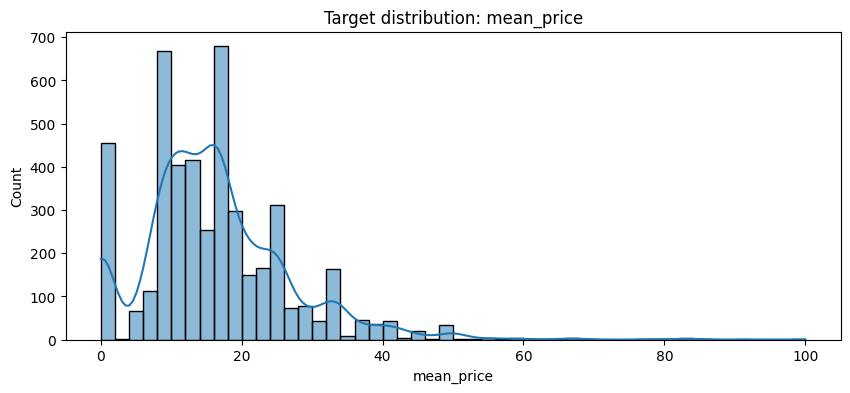

Target stats:
count    4548.000000
mean       16.197949
std        10.485108
min         0.041667
25%        10.000000
50%        15.000000
75%        20.888889
max       100.000000
Name: mean_price, dtype: float64


In [136]:
plt.figure(figsize=(10, 4))
sns.histplot(y, bins=50, kde=True)
plt.title("Target distribution: mean_price")
plt.show()

print("Target stats:")
print(y.describe())

Проанализировано распределение целевой переменной mean_price.
Часто распределение цен имеет тяжёлый хвост и скошенность, поэтому в дальнейшем разумно рассмотреть логарифмирование таргета или использование регуляризованных моделей для устойчивости.

In [137]:
X["tutor_reviews_log"] = np.log1p(X["tutor_reviews"])
test_df["tutor_reviews_log"] = np.log1p(test_df["tutor_reviews"])

Создан дополнительный признак tutor_reviews_log, который сглаживает распределение количества отзывов.
Логарифмирование полезно, так как влияние отзывов на стоимость обычно не линейное, а модель Ridge лучше работает с такими преобразованными признаками.

In [ ]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()


text_features = [
    "description",
    "experience_desc",
    "categories",
    "tutor_head_tags"
]


cat_features = [c for c in categorical_features if c not in text_features]

print("Numeric:", numeric_features)
print("Categorical:", cat_features)
print("Text:", text_features)

Numeric: ['tutor_rating', 'tutor_reviews', 'tutor_reviews_log']
Categorical: ['предмет', 'ФИО', 'Education_1', 'Desc_Education_1', 'Education_2', 'Desc_Education_2', 'Education_3', 'Desc_Education_3', 'Education_4', 'Desc_Education_4', 'Ученая степень 1', 'Ученое звание 1', 'status', 'experience', 'Desc_Education_5', 'Desc_Education_6', 'Education_5', 'Education_6', 'Ученая степень 2', 'Ученое звание 2']
Text: ['description', 'experience_desc', 'categories', 'tutor_head_tags']


Признаки корректно классифицированы по типам:
- числовые - будут заполняться и передаваться напрямую,
- категориальные - будут кодироваться One-Hot Encoder,
- текстовые - будут преобразованы в TF-IDF.
Этот шаг обеспечивает правильную обработку смешанных данных в ColumnTransformer.

In [139]:
def to_str_fillna(x):
    """
    x приходит как Series (1D) или DataFrame (2D).
    Приводим к Series, заполняем NaN, приводим к строке.
    """
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    return x.fillna("").astype(str)

Добавлена функция to_str_fillna, которая гарантирует корректный вход для TfidfVectorizer:
значения переводятся в строки и пропуски заменяются пустыми строками.
Это устраняет типовую ошибку sklearn, возникающую при передаче векторизатору Series с NaN.

In [140]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

text_transformers = []
for col in text_features:
    text_transformers.append(
        (
            f"tfidf_{col}",
            Pipeline(steps=[
                ("to_str", FunctionTransformer(to_str_fillna, validate=False)),
                ("tfidf", TfidfVectorizer(
                    max_features=8000,
                    ngram_range=(1, 1),
                    min_df=3
                ))
            ]),
            col
        )
    )

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, cat_features),
        *text_transformers
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e

Собран единый preprocessor, который обеспечивает воспроизводимую обработку данных:
- числовые признаки - импьютинг медианой,
- категориальные - импьютинг + One-Hot Encoding,
- текстовые - TF-IDF с заданными параметрами.

Использование ColumnTransformer позволяет избежать ручной обработки train/test и предотвращает утечки данных.

In [141]:
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "ElasticNet(alpha=1.0,l1_ratio=0.5)": ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=RANDOM_STATE)
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    scores = cross_val_score(
        pipe, X, y,
        scoring="neg_mean_squared_error",
        cv=cv,
        n_jobs=1
    )
    
    mse = -scores
    results.append({
        "model": name,
        "mse_mean": mse.mean(),
        "mse_std": mse.std(),
        "rmse_mean": np.sqrt(mse.mean())
    })

results_df = pd.DataFrame(results).sort_values("rmse_mean")
results_df

f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At l

,model,mse_mean,mse_std,rmse_mean
1,Ridge(alpha=1.0),82.690836,6.744448,9.093450
0,LinearRegression,84.650381,7.133320,9.200564
2,"ElasticNet(alpha=1.0,l1_ratio=0.5)",107.876027,5.058120,10.386338


Проведено сравнение нескольких моделей регрессии с кросс-валидацией.
Метрика RMSE позволяет оценить качество предсказаний в единицах таргета.
На этом шаге выбирается лучшая базовая модель для дальнейшей оптимизации.

In [142]:
ridge_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Ridge(random_state=RANDOM_STATE))
])

param_grid = {
    "model__alpha": [0.1, 0.3, 0.5, 1.0, 2.0, 5.0, 10.0]
}

grid = GridSearchCV(
    ridge_pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=1,
    verbose=2
)

grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV MSE:", -grid.best_score_)
print("Best CV RMSE:", np.sqrt(-grid.best_score_))


Fitting 3 folds for each of 7 candidates, totalling 21 fits


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ...................................model__alpha=0.1; total time=   0.8s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ...................................model__alpha=0.1; total time=   0.7s
[CV] END ...................................model__alpha=0.1; total time=   0.8s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ...................................model__alpha=0.3; total time=   0.6s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ...................................model__alpha=0.3; total time=   0.7s
[CV] END ...................................model__alpha=0.3; total time=   0.7s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ...................................model__alpha=0.5; total time=   0.7s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ...................................model__alpha=0.5; total time=   0.7s
[CV] END ...................................model__alpha=0.5; total time=   0.6s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ...................................model__alpha=1.0; total time=   0.6s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ...................................model__alpha=1.0; total time=   0.6s
[CV] END ...................................model__alpha=1.0; total time=   0.6s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ...................................model__alpha=2.0; total time=   0.6s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ...................................model__alpha=2.0; total time=   0.6s
[CV] END ...................................model__alpha=2.0; total time=   0.6s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ...................................model__alpha=5.0; total time=   0.5s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ...................................model__alpha=5.0; total time=   0.6s
[CV] END ...................................model__alpha=5.0; total time=   0.6s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Ученая степень 2' 'Ученое звание 2']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ..................................model__alpha=10.0; total time=   0.5s


f:\Homework\ml_hm_5\.venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Desc_Education_6' 'Education_6']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


[CV] END ..................................model__alpha=10.0; total time=   0.5s
[CV] END ..................................model__alpha=10.0; total time=   0.5s
Best params: {'model__alpha': 5.0}
Best CV MSE: 80.85124756582672
Best CV RMSE: 8.991732178275036


Выполнен подбор гиперпараметра alpha для модели Ridge.
Регуляризация критически важна при наличии большого количества разреженных признаков (TF-IDF + OHE), так как помогает снизить переобучение и улучшить обобщающую способность модели.

In [143]:
best_model = grid.best_estimator_
best_model.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

Лучшая модель (best_estimator_) обучена на полном тренировочном наборе.
Это позволяет максимально использовать доступные данные перед предсказанием на тестовом наборе и формированием финального submission.

In [144]:
test_pred = best_model.predict(test_df)

print("Pred shape:", test_pred.shape)
print("Pred stats:", pd.Series(test_pred).describe())


Pred shape: (1516,)
Pred stats: count    1516.000000
mean       16.231392
std         5.441482
min         3.301657
25%        12.459347
50%        15.632599
75%        18.966954
max        44.534515
dtype: float64


Получены предсказания целевой переменной mean_price для тестового набора.
Проверена размерность результата — она соответствует количеству строк в test_df.

In [145]:
submission = pd.DataFrame({
    "index": np.arange(len(test_pred)),
    "mean_price": test_pred
})

submission.head()


,index,mean_price
0,0,16.872662
1,1,15.525145
2,2,24.005122
3,3,11.020929
4,4,9.459505


In [146]:
SUBMISSION_PATH = "submission.csv"
submission.to_csv(SUBMISSION_PATH, index=False)

print("Saved:", SUBMISSION_PATH)


Saved: submission.csv


In [148]:
print("NaN in submission:", submission.isna().sum())

NaN in submission: index         0
mean_price    0
dtype: int64


![Leaderboard](image.png)

Загрузил предсказания на Kaggle и получил результат 52.60081 (RMSE)